### Milestone 3 - Implementing Customized Art Classifier

---  

# Objective of this notebook
* Build a CNN model from scratch
* Train the model on art paintings dataset
* Compare and visualize its performance on different art classes

> **Note:** The content of this notebook follows the description provided in [Milestone-3](./Milestone-3.md)

---
## 1. Prerequisites

### Importing packages & modules
You might prefer to load the required modules/packages when required. Feel free to do so if it is your preference

In [2]:
# Common modules/packages
import matplotlib.pyplot as plt
import math
import numpy as np
import pathlib
import sys, shutil, time
import warnings

# PyTorch modules/packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torchvision import datasets, models, transforms
from PIL import ImageFile

%matplotlib inline
warnings.filterwarnings('ignore')

### Setting up the training mode based on CUDA capability

In [3]:
device = 'cpu'  #sets the default value
train_on_gpu = torch.cuda.is_available()  #returns True if CUDA enabled GPU is available

if train_on_gpu == True :
    print('CUDA is available!  Training on GPU ...')
    print('\n')
    print(torch.cuda.get_device_properties(0))
    device = 'cuda'

### Define some utilities functions  
These functions will be used to load the dataset

In [4]:
# Retrieves the list of files with a directory
def getFilesInDirectory(pathToDir, extension = "*.*"):
    if not isinstance(pathToDir, pathlib.PurePath):
        pathToDir = pathlib.Path(pathToDir)

    return list(pathToDir.glob(extension))

# Retrieves the list of folders with a directory
def getFoldersInDirectory(pathToDir, prefix = ""):
    if not isinstance(pathToDir, pathlib.PurePath):
        pathToDir = pathlib.Path(pathToDir)

    return sorted([fld for fld in pathToDir.iterdir() if fld.is_dir() and not fld.name.lower().startswith(prefix)])

# Retrieves the list of folders with a directory
def getFolderNamesInDirectory(pathToDir, prefix = ""):
    if not isinstance(pathToDir, pathlib.PurePath):
        pathToDir = pathlib.Path(pathToDir)

    return sorted([fld.name for fld in pathToDir.iterdir() if fld.is_dir() and not fld.name.lower().startswith(prefix)])

## 2. Prepare the dataset

The folder structure created through Milestone 1 should looks like this:
```
dataset/train/artCategory_1/file_01.jpg
dataset/train/artCategory_1/file_03.jpg
dataset/train/artCategory_1/file_06.jpg
...
dataset/test/artCategory_1/file_02.jpg
...
dataset/valid/artCategory_1/file_04.jpg
```

The root folder for training is `dataset/train` and the classes are the names of art types.
Likewise, `dataset/valid` and `dataset/test` for validation and testing respectively.

> **Note:**
>   - If you have downloaded images through Milestone 1, the expected folder structure above should be already present
>   - If you have used the set of images (image-sets.zip) provided, please note these images have the following format: 432*288

### Sets the folders
* Set the location for `train`, `test` and `valid` folders
* Count the number of Art category and list them using the function above

In [6]:
# DEFINE DATA DIRECTORIES & LOCATION OF IMAGE-SETS ARCHIVE
# --------------------------------------------------------

# sets the root folder for image sets
pathToDataset = pathlib.Path.cwd().joinpath('dataset')
pathToTrain = pathToDataset.joinpath('train')
pathToTest = pathToDataset.joinpath('test')
pathToValid = pathToDataset.joinpath('valid')

# count and list art category
artCategories = getFolderNamesInDirectory(pathToTrain, ".")  # collects the list of folders

print("Total no. of categories = ", len(artCategories))
print("Categories: ", artCategories)

Total no. of categories =  6
Categories:  ['cubism', 'genre', 'landscape', 'portrait', 'still-life', 'surrealism']


### Transformations

Let's assume that our model expects a `224`-dim square image as input. Resizing will therefore be required for each art image to fit this model. These transformations applies on `train`, `test` and `valid`. Use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class, which makes it very easy to load data from a directory. 

***A. Data-Augmentation***  
Using data augmentation on training images.
1. Randomly rotating the training by 30 degress.
2. Randomly cropping and resizing it to 224-dim square image.  
    !!! Please use only one function that crops the given image to random size and aspect ratio.
3. Randomly flipping it horizontally.

> **Note:** 
Data augmentation isn't applied on validation and testing set. These images are resized to 256 pixels and then cropped from center to make it 224-dim square images.  

***B. Normalization:***  
The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. Same normalization was used by these pre-trained models for training.

In [8]:
# Define the data-augmentation transforms including normalisations
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
                 
test_transforms  = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
                 
valid_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

# load and apply above transforms on dataset using ImageFolder
train_dataset = datasets.ImageFolder(pathToTrain, transform=train_transforms)
test_dataset  = datasets.ImageFolder(pathToTest , transform=test_transforms)
valid_dataset = datasets.ImageFolder(pathToValid, transform=valid_transforms)

# Print out data stats
print('Training  images: ', len(train_dataset))
print('Testing   images: ', len(test_dataset))
print('Validation images:', len(valid_dataset))

Training  images:  745
Testing   images:  499
Validation images: 1248


### Data Loading
A [data loader](https://pytorch.org/docs/stable/data.html) is an iterable over a dataset. The parameters are:
* `batch`:  number of samples per batch to be loaded
* `shuffle`: set to True, data are reshuffled at every epoch.
* `num_workers`: nbr of subprocesses to use for data loading

In [9]:
# Define dataloader parameters
batch_size = 16  # You might want to increase the size to 32. This might raise an exception 
num_workers = 0

# Prepare data loaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle = True)
test_dataloader  = torch.utils.data.DataLoader(test_dataset , batch_size=batch_size, num_workers=num_workers, shuffle = False)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle = False)

# Print the batches stats
print('Number of  training  batches:', len(train_dataloader))
print('Number of  testing   batches:', len(test_dataloader))
print('Number of validation batches:', len(valid_dataloader))

Number of  training  batches: 47
Number of  testing   batches: 32
Number of validation batches: 78


---
## Optional - Data visualization
> **Note:** the below code is not part of the model training/testing. 

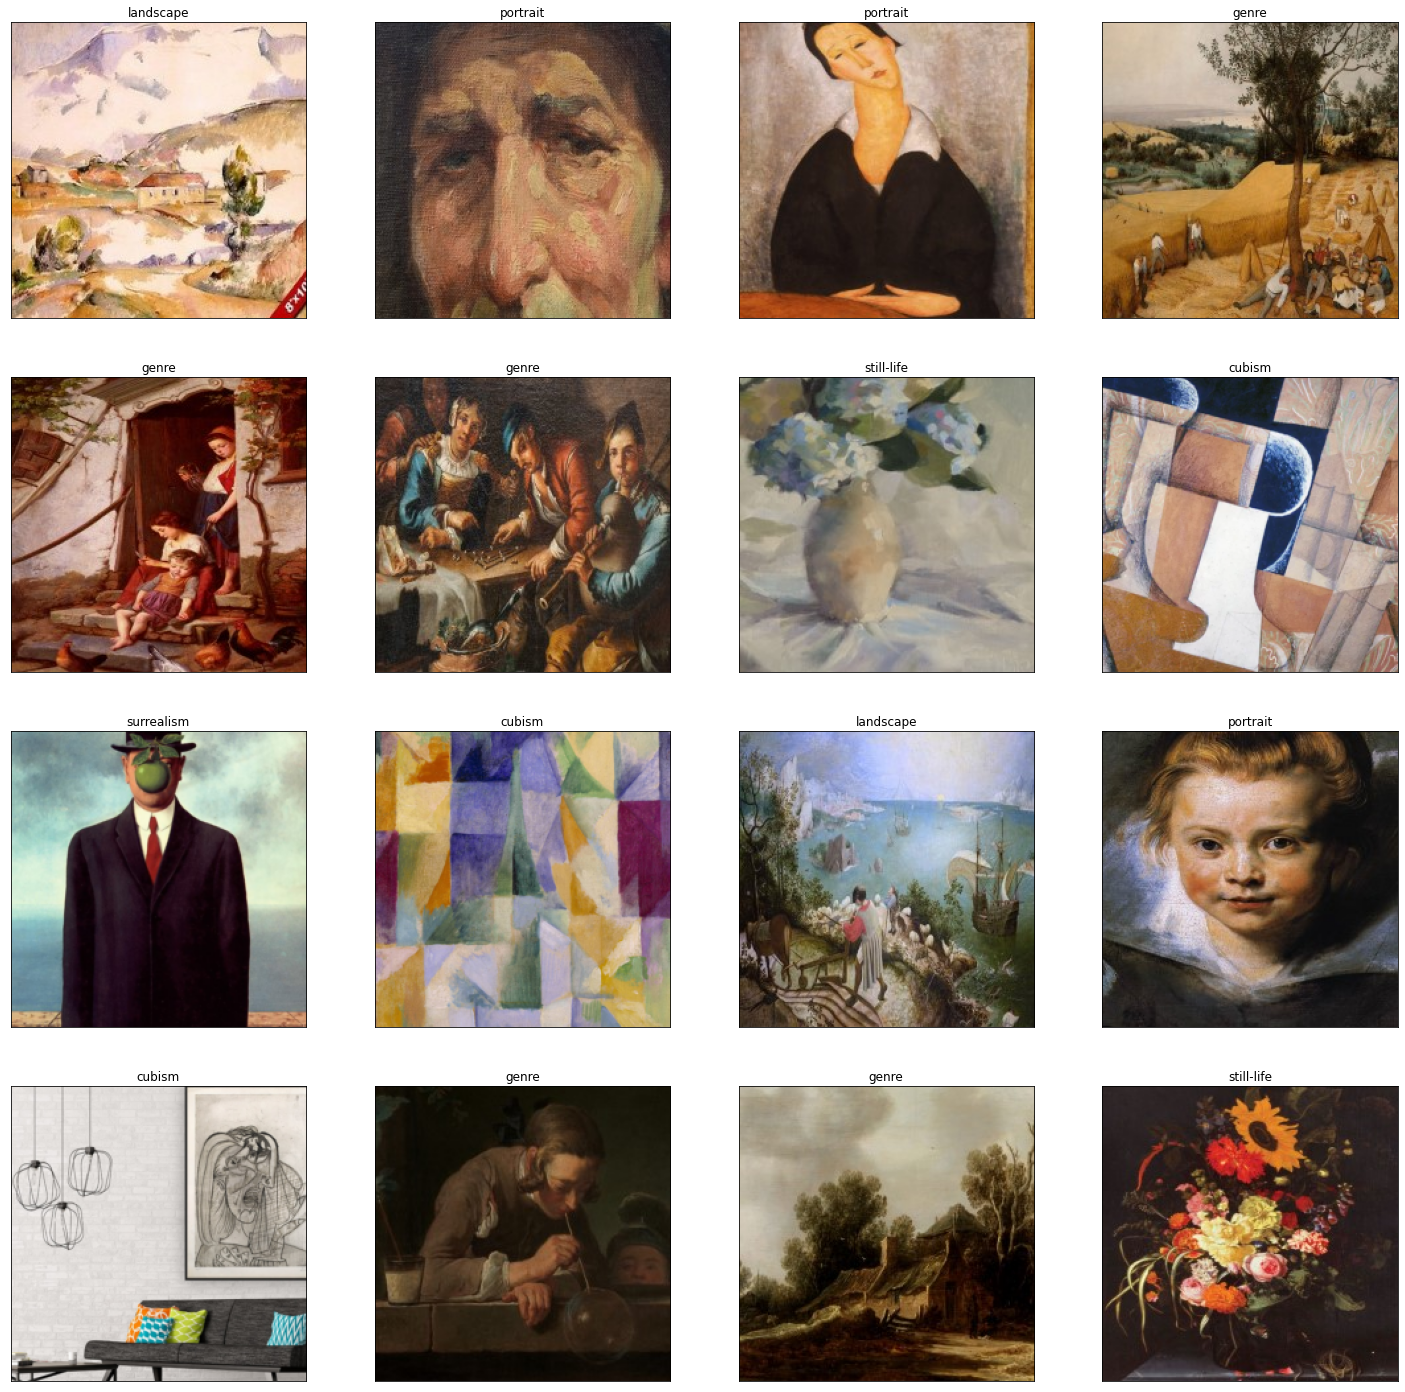

In [10]:
# Ignore normalization and turn shuffle ON to visualize different classes together
visual_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor()])

# Load and apply above transforms on dataset using ImageFolder
# Use test directory images can be used for visualization
visual_dataset = datasets.ImageFolder(pathToTest ,transform=visual_transforms)

# Prepare data loaders
visualization_dataloader = torch.utils.data.DataLoader(visual_dataset, batch_size = batch_size, num_workers = num_workers, shuffle=True)

# Obtain one batch of testing images
dataiter = iter(visualization_dataloader)
images, labels = dataiter.next()

# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch along with the corresponding labels
plotCols = 4
plotRows = math.ceil(batch_size/plotCols) # SqRoot could be used as well: math.ceil(math.sqrt(batch_size))
fig = plt.figure(figsize=(25, 25))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(plotRows, plotCols, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(artCategories[labels[idx]])

## 3. Modelling

### 3.1. Definition

Define a model based on a class inherited from nn.Module which will take in a 224x224 dimensional image.

1. Initialise a CNN model  
This class function (`__init()__`) defines the architecture or flow of the model.  

	* 5 convolutional layers configured as such:  
		* input/output filters: 3, 8, 16, 32, 64, respectively
		* filter size: 224*224, 112*112, 56*56, 28*28, 14*14

		Each layer uses a kernel size of 3x3, stride and padding value of 1.

	* Max pooling layer with a kernel size of 2*2 and stride as 2. This layer takes the output of convolutional layer and decreases the dimensionality by half.
	* 3 fully connected layers with an output of 1024 and 256, `x` nodes, respectively. `x` represents the number of art classes processed.
	
	The example below shows how to create a single layer.
For ex: `self.conv1 = nn.Conv2d(3,  8, 3, stride = 1, padding = 1)` where the arguments are in_depth, out_depth, kernel_size, stride, padding. Here `self.conv1` is user define variable which denotes the given layer. In this manner, we can create multiple layers and assign each one to its respective variable name.

2. Model Architecture/Flow  
This class function (`forward()`) defines the architecture or flow of the model.
	* Using the layer variables created in the above init() function, provide a sequential pathway for the tensors to pass through the layers define earlier.
	* Provide the activation function applied on the layer.  For ex: `x = F.relu(self.conv1(x))`.

	The flow is as follow:
	* Set the `relu` activation function to each convolutional layer
	* Set a max pooling layer after each convolutional layer
	* Set the `relu` activation function and dropout to each fully connected layers.


In [11]:
# define the CNN architecture
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d( 3,  8, 3, stride = 1, padding = 1)    # takes in 224*224
        self.conv2 = nn.Conv2d( 8, 24, 3, stride = 1, padding = 1)    # takes in 112*112
        self.conv3 = nn.Conv2d(24, 72, 3, stride = 1, padding = 1)    # takes in 56*56
        self.conv4 = nn.Conv2d(72, 144, 3, stride = 1, padding = 1)   # takes in 28*28
        self.conv5 = nn.Conv2d(144,288, 3, stride = 1, padding = 1)   # takes in 14*14

        self.maxpool = nn.MaxPool2d(2,2)        

        self.dropout = nn.Dropout(p=0.2)

        self.fc1 = nn.Linear(288*7*7, 4096) # input to fc1 is (output filters of conv. part = 64) * (dimensions of each = 14*14) 
        self.fc2 = nn.Linear(4096, 512)
        self.fc3 = nn.Linear(512, 14)
        
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))  # takes 224*224
        x = self.maxpool(x)        # gives 112*112 
        x = F.relu(self.conv2(x))  # takes 112*112
        x = self.maxpool(x)        # gives 56*56
        x = F.relu(self.conv3(x))  # takes 56*56
        x = self.maxpool(x)        # gives 28*28
        x = F.relu(self.conv4(x))  # takes 28*28
        x = self.maxpool(x)        # gives 14*14
        x = F.relu(self.conv5(x))  # takes 14*14
        x = self.maxpool(x)        # gives 7*7
        
        x = x.view(-1, 288*7*7)    # flattening output of convolutional part

        x = self.dropout(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))

        x = self.fc3(x)            # dropout and activation function is not used on last layer
        
        return x

# instantiate the CNN
model_scratch = Net()

# move model to GPU if CUDA is available
if train_on_gpu == True:
    model_scratch.to(device)

print(model_scratch)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(24, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(72, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(144, 288, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=14112, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=14, bias=True)
)


3. Set the model name and its location

In [16]:
model_name = 'ArtClassifier'
model_filename = 'trained_' + model_name + '.pt'
pathToModel = pathlib.Path.cwd().joinpath('dataset','models', model_filename)
print('File name for saved model: ', pathToModel)

File name for saved model:  C:\Users\david\Google Drive\Reviews\Manning\LiveProjects\Art\dataset\models\trained_ArtClassifier.pt


4. Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

    Let's define a criterion and an optimizer that will work "together". The criterion will be used to stop the algorithm when it approaches the optimum.  

    We will use [ADAM](https://arxiv.org/abs/1412.6980) algorithm as optimizer and use the Cross-Entropy Loss function as criterion. Note that the optimizer accepts as input _only_ the trainable parameters.



In [13]:
### TODO: select loss function
criterion = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer = optim.Adam(model_scratch.parameters(), lr = 0.001)


### 3.2. Model Training

1. Training Preparation  

    The following variables will be defined:
    * The number of epochs required for the training and validation of the model
    * The minimal value for validation loss
    * Some performance variables such as:
        * the losses for training and validation
        * the model accuracy


In [14]:
# Some images in dataset were truncated (maybe corrupted)
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set number of epochs to train the model
n_epochs = 40

# Initialize tracker for minimum validation loss
valid_loss_min = np.Inf   # set initial "min" to infinity

# Initialise performances
train_losses, valid_losses, accuracies=[],[],[]
training_loss = 0.0
validation_loss = 0.0
accuracy = 0.0

2. Train & Validation the model

    **Training**  
    The training will be performed by going through every epoch.  

    * Collect a set of labelled images and for each image:
        * execute the `forward` method
        * calculate the loss using the criterion and the gradient of the loss
        * apply a single step optimization
        * refresh the training loss

    **Validate**  
    The validation will be performed by going through every epoch - same as the training.

    * Place the model into validation model
        * execute the `forward` method
        * calculate the validation loss and the accuracy
        * compare your predictions against the true labels
        * incrementing values of 'accuracy' with equals
    * Save the model if validation loss has decreased

    Lastly, for each epoch, print the performance variables.


In [17]:
a = time.time()  #Start-time for training

for epoch in range(1, n_epochs+1):
    c = time.time()  #Start-time for epoch
    
    ###############
    # TRAIN MODEL #
    ###############
        
    # model by default is set to train
    for batch_i, (images, labels) in enumerate(train_dataloader): #Getting one batch of training images and their corresponding true labels
        
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images = images.to(device)
            labels = labels.to(device)
            
        # clear the previous/buffer gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model_scratch.forward(images)
        
        # calculate the batch loss
        loss = criterion(outputs, labels)    #(y_hat, y)  or (our-prediction, true-label)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss 
        training_loss += loss.item()
        
    ##################
    # VALIDATE MODEL #
    ##################      
    
    #validation loss and accuracy
    validation_loss = 0.0
    accuracy = 0.0

    model_scratch.eval() #model is put to evalution mode i.e. dropout is switched off

    with torch.no_grad():  #Turning off calculation of gradients (not required for validaiton)  {saves time}
        for images, labels in valid_dataloader:   #Getting one batch of validation images
            
            if train_on_gpu:   #moving data to GPU if available
                images = images.to(device)
                labels = labels.to(device)

            outputs = model_scratch.forward(images)

            # calculate the batch loss
            batch_loss = criterion(outputs, labels)
            validation_loss += batch_loss.item()
            
            # Calculating accuracy
            ps = torch.exp(outputs)   #Turning raw output values into probabilities using exponential function

            #getting top one probablilty and its corresponding class for batch of images
            top_p, top_class = ps.topk(1, dim=1) 

            #Comparing our predictions to true labels
            equals = top_class == labels.view(*top_class.shape)   #equals is a list of values

            #incrementing values of 'accuracy' with equals
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()   #taking average of equals will give number of true-predictions
                                                #equals if of ByteTensor (boolean), changing it to FloatTensor for taking mean...
    
    train_losses.append(training_loss/len(train_dataloader))    
    valid_losses.append(validation_loss/len(valid_dataloader))
    accuracies.append(((accuracy/len(valid_dataloader))*100.0))
    d = time.time() #end-time for epoch
    
    print(f"Epoch {epoch} "
          f"Time: {int((d-c)/60)} min {int(d-c)%60} sec "
          f"Train loss: {training_loss/len(train_dataloader):.2f}.. "
          f"Validation loss: {validation_loss/len(valid_dataloader):.2f}.. "
          f"Validation accuracy: {((accuracy/len(valid_dataloader))*100.0):.2f}% "
          )

    training_loss = 0.0

    # save model if validation loss has decreased
    if ( validation_loss/len(valid_dataloader) <= valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min , validation_loss/len(valid_dataloader)))
        torch.save(model_scratch.state_dict(), pathToModel) #Saving model 
        valid_loss_min = validation_loss/len(valid_dataloader)   #Minimum validation loss updated

    #After validation, model is put to training mode i.e. dropout is again switched on
    model_scratch.train()

    ################
    # END OF EPOCH #
    ################

b = time.time()  #end-time for training
print('\n\n\tTotal training time: ' , int((b-a)/(60*60)), "hour(s) " , int(((b-a)%(60*60))/60),"minute(s) ", int(((b-a)%(60*60))%60) , "second(s)")

Epoch 1 Time: 1 min 18 sec Train loss: 1.57.. Validation loss: 1.64.. Validation accuracy: 31.09% 
Validation loss decreased (inf --> 1.644442).  Saving model ...
Epoch 2 Time: 1 min 21 sec Train loss: 1.50.. Validation loss: 1.60.. Validation accuracy: 33.01% 
Validation loss decreased (1.644442 --> 1.601675).  Saving model ...
Epoch 3 Time: 1 min 19 sec Train loss: 1.43.. Validation loss: 1.72.. Validation accuracy: 38.06% 
Epoch 4 Time: 1 min 28 sec Train loss: 1.38.. Validation loss: 1.58.. Validation accuracy: 36.94% 
Validation loss decreased (1.601675 --> 1.577770).  Saving model ...
Epoch 5 Time: 1 min 32 sec Train loss: 1.42.. Validation loss: 1.53.. Validation accuracy: 40.38% 
Validation loss decreased (1.577770 --> 1.534204).  Saving model ...
Epoch 6 Time: 1 min 27 sec Train loss: 1.36.. Validation loss: 1.65.. Validation accuracy: 35.90% 
Epoch 7 Time: 1 min 27 sec Train loss: 1.33.. Validation loss: 1.67.. Validation accuracy: 29.89% 
Epoch 8 Time: 1 min 27 sec Train los

3. Load the Model with the Lowest Validation Loss

In [19]:
model_scratch.load_state_dict(torch.load(pathToModel))

<All keys matched successfully>

### 3.3. Testing

1. Testing Preparation  

    The following variables will be defined:
    * The number of epochs required for the training and validation of the model
    * The minimal value for validation loss
    * Some performance variables such as:
        * the losses for training and validation
        * the model accuracy


In [20]:
test_loss = 0.0
counter = 0

class_correct = list(0. for i in range(len(artCategories)))
class_total = list(0. for i in range(len(artCategories)))
classes_accuracies=[]

# evaluation mode (switching off dropout)
model_scratch.eval()

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(24, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(72, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(144, 288, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=14112, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=14, bias=True)
)

2. Testing the model  

    * Collect a set of labelled images and for each image:
        * send each image to the model and collect the output
        * based on the output and the label, evaluate the loss
        * convert the output probabilities to a predicted class
        * for each art category, calculate the test accuracy


In [21]:
# Iterate over test data - get one batch of data from testloader
for images, labels in test_dataloader:
    
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        images = images.to(device)
        labels = labels.to(device)
    
    # compute predicted outputs by passing inputs to the model
    output = model_scratch(images)
    
    # calculate the batch loss
    loss = criterion(output, labels)
    
    # update test loss 
    test_loss += loss.item() * images.size(0)
    
    # Convert output probabilities to predicted class
    ps, pred = torch.max(output, 1)    
    
    # Compare model's predictions to true labels
    for i in range(len(images)):
        class_total[labels[i]] += 1
        if pred[i] == labels[i]:
            class_correct[pred[i]] += 1
    counter += 1

# calculate average test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(artCategories)):
    classes_accuracies.append(100 * class_correct[i] / class_total[i])
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            artCategories[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (artCategories[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % 
                          (100. * np.sum(class_correct) / np.sum(class_total),np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.226486

Test Accuracy of cubism: 76% (42/55)
Test Accuracy of genre: 45% (54/118)
Test Accuracy of landscape: 69% (67/96)
Test Accuracy of portrait: 62% (70/112)
Test Accuracy of still-life: 33% (27/81)
Test Accuracy of surrealism:  5% ( 2/37)

Test Accuracy (Overall): 52% (262/499)


## 4. Saving the best model

Additional performance will be saved along with `Training Loss`, `Validations Loss`, `Accuracy`, `Class Accuracy`

In [22]:
checkpoint = {'training_losses': train_losses,
              'valid_losses': valid_losses,
              'accuracies': accuracies,
              'classes_accuracies':classes_accuracies,
              'state_dict': model_scratch.state_dict()}

torch.save(checkpoint, model_filename)

---
## Optional - Data visualization
> **Note:** the below code is not part of the model training/testing.

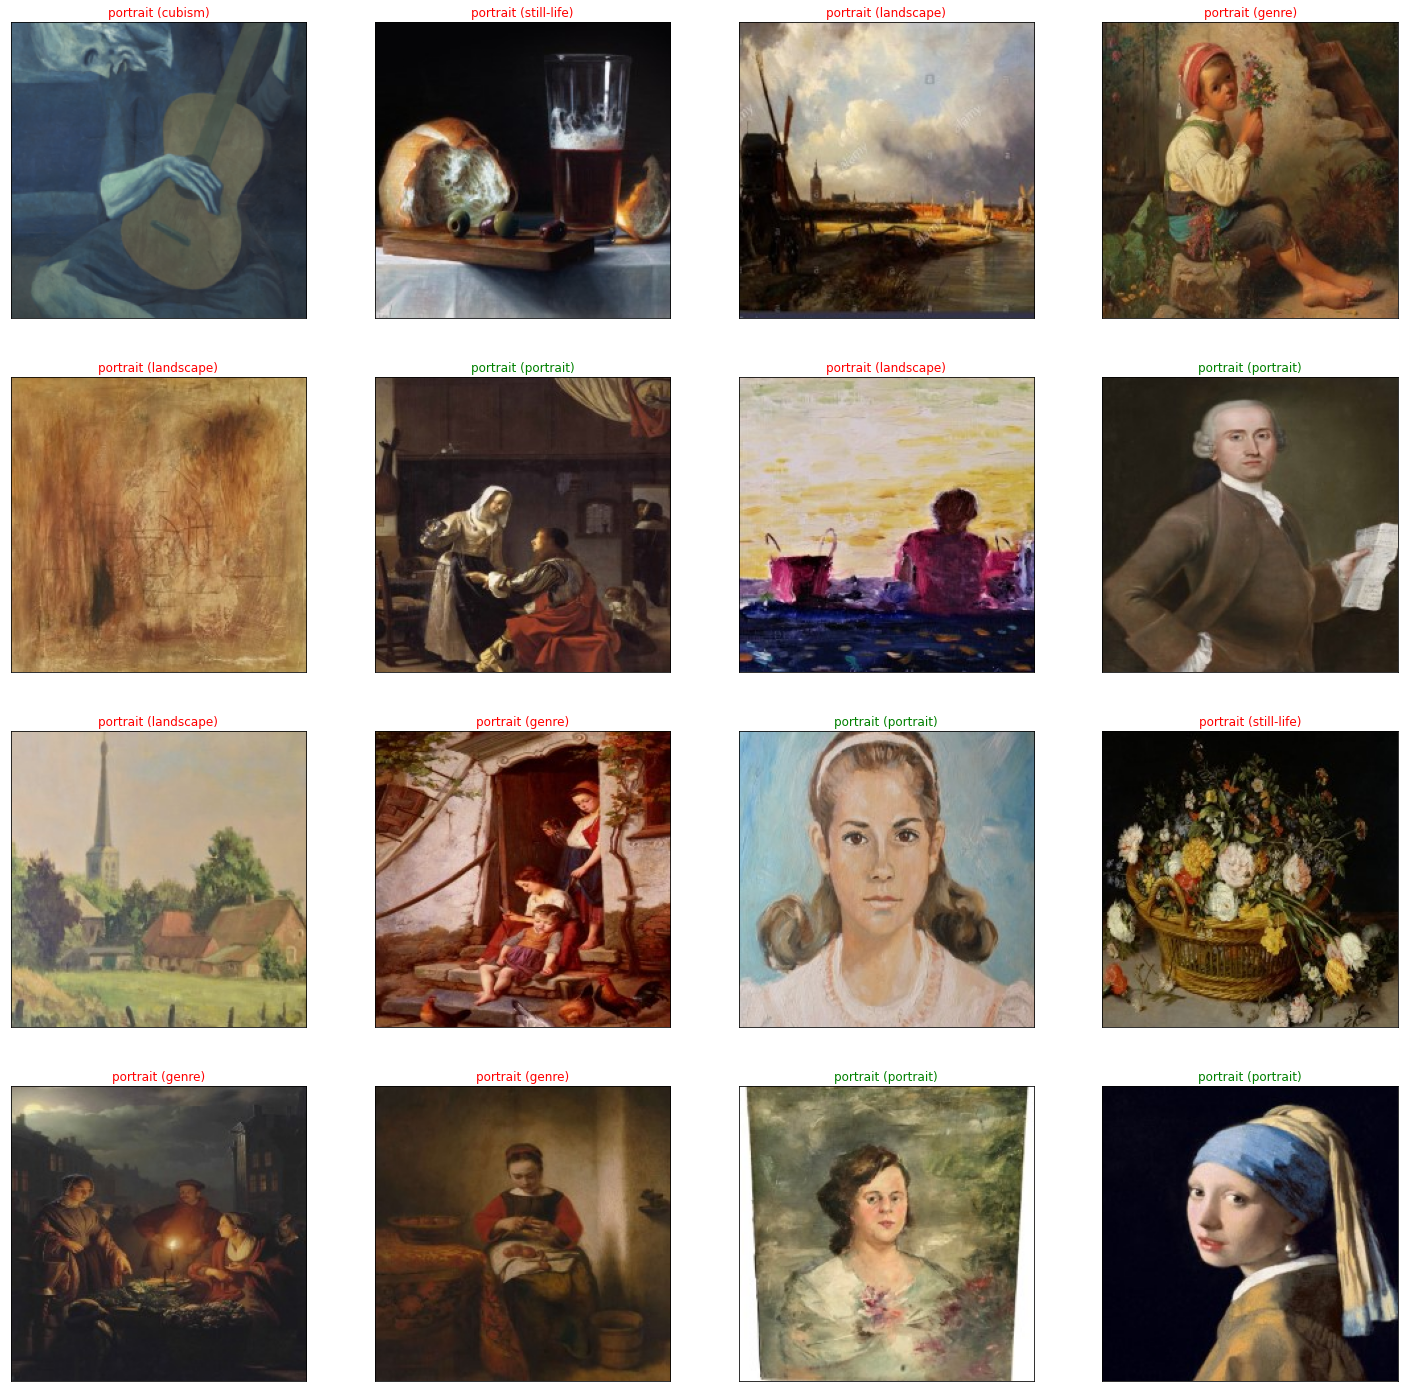

In [24]:
# obtain one batch of test images
dataiter = iter(visualization_dataloader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:    
    images = images.to(device)
    
# get sample outputs
output = model_scratch(images)

#move images to CPU for plotting
images = images.cpu()

# convert output probabilities to predicted class
output_ps, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# Plot the images in the batch along with the corresponding labels
plotCols = 4
plotRows = math.ceil(batch_size/plotCols) # SqRoot could be used as well: math.ceil(math.sqrt(batch_size))
fig = plt.figure(figsize=(25, 25))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(plotRows, plotCols, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(artCategories[preds[idx]], artCategories[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))